# Baywheels ride sharing data analysis

  > by Sahithi Indarapu

## Introduction to Baywheels

Bay Wheels (Used to be FordGo bike) is a regional public bicycle sharing system in the San Francisco Bay Area, California operated by Motivate in a partnership with the Metropolitan Transportation Commission and the Bay Area Air Quality Management District. Bay Wheels is the first regional and large-scale bicycle sharing system deployed in California and on the West Coast of the United States. It was established as Bay Area Bike Share in August 2013. As of January 2018, the Bay Wheels system had over 2,600 bicycles in 262 stations across San Francisco, East Bay and San Jose. On June 28, 2017, the system officially re-launched as Ford GoBike in a partnership with Ford Motor Company. After Motivate's acquisition by Lyft, the system was subsequently renamed to Bay Wheels in June 2019. The system is expected to expand to 7,000 bicycles around 540 stations in San Francisco, Oakland, Berkeley, Emeryville, and San Jose.[1]

## Preliminary Wrangling


In [96]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

import zipfile
import glob
import os
import math
import requests
import io

%matplotlib inline

In [2]:
raw_data = "raw_data"

fordgobike = "fordgobike"
baywheels = "baywheels"
# The placeholders should have year, month and then provider.
# Provider changed from ford gobike to baywheels from 2019 May.
baseUrl = "https://s3.amazonaws.com/baywheels-data/{}{}-{}-tripdata.csv.zip"

In [52]:
def download_and_extract_file(url: str, targetDir: str = raw_data):
    print("fetching {}".format(url))
    r = requests.get(url)
    if r.status_code != 200:
        print("error fetching {} : {}".format(url, r.reason))
        return
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(targetDir)

url_2017 = baseUrl.format("2017", "", fordgobike)
download_and_extract_file(url_2017)

current_year = 2020
current_month = 1

for year in range(2018, current_year):
    for month in range(1, 13):
        provider = fordgobike
        if year >= 2019 and month >= 5:
            provider = baywheels
        url = baseUrl.format(year, "{:02d}".format(month), provider)
        download_and_extract_file(url)

for month in range(1, current_month + 1):
    url = baseUrl.format(current_year, "{:02d}".format(month), baywheels)
    download_and_extract_file(url)

fetching https://s3.amazonaws.com/baywheels-data/2017-fordgobike-tripdata.csv.zip
fetching https://s3.amazonaws.com/baywheels-data/201801-fordgobike-tripdata.csv.zip
fetching https://s3.amazonaws.com/baywheels-data/201802-fordgobike-tripdata.csv.zip
fetching https://s3.amazonaws.com/baywheels-data/201803-fordgobike-tripdata.csv.zip
fetching https://s3.amazonaws.com/baywheels-data/201804-fordgobike-tripdata.csv.zip
fetching https://s3.amazonaws.com/baywheels-data/201805-fordgobike-tripdata.csv.zip
fetching https://s3.amazonaws.com/baywheels-data/201806-fordgobike-tripdata.csv.zip
fetching https://s3.amazonaws.com/baywheels-data/201807-fordgobike-tripdata.csv.zip
fetching https://s3.amazonaws.com/baywheels-data/201808-fordgobike-tripdata.csv.zip
fetching https://s3.amazonaws.com/baywheels-data/201809-fordgobike-tripdata.csv.zip
fetching https://s3.amazonaws.com/baywheels-data/201810-fordgobike-tripdata.csv.zip
fetching https://s3.amazonaws.com/baywheels-data/201811-fordgobike-tripdata.cs

In [3]:
# Read all csv files in the data directory.
all_files = glob.glob(os.path.join(raw_data, "*.csv"))

# Explictly mention column data types to suppress low memory warnings caused by pandas guessing the dtype.
# See https://stackoverflow.com/questions/24251219/pandas-read-csv-low-memory-and-dtype-options
dtypes={'user_type': str, 'bike_share_for_all_trip': str, 'rental_access_method': str}

# Pass sort=False to concat method to adhere to future behavior and suppress deperecation warnings
# See https://stackoverflow.com/questions/50501787/python-pandas-user-warning-sorting-because-non-concatenation-axis-is-not-aligne
raw_df = pd.concat((pd.read_csv(f, dtype=dtypes) for f in all_files), ignore_index = True, sort=False)

In [4]:
raw_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5186258 entries, 0 to 5186257
Data columns (total 15 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   duration_sec             5186258 non-null  int64  
 1   start_time               5186258 non-null  object 
 2   end_time                 5186258 non-null  object 
 3   start_station_id         4944185 non-null  float64
 4   start_station_name       4945366 non-null  object 
 5   start_station_latitude   5186258 non-null  float64
 6   start_station_longitude  5186258 non-null  float64
 7   end_station_id           4941665 non-null  float64
 8   end_station_name         4942794 non-null  object 
 9   end_station_latitude     5186258 non-null  float64
 10  end_station_longitude    5186258 non-null  float64
 11  bike_id                  5186258 non-null  int64  
 12  user_type                5186258 non-null  object 
 13  bike_share_for_all_trip  4359974 non-null 

### Structure of your dataset

FordGo bike data as the name suggests is a bike ride data. The data is pretty descriptive and easy to understand. This specific jupyter notebook here is dealing with bike sharing data from 2017 to 2019. The data collected here is informative sparing few missing values. The project here follows all the four steps of data analysis process where the data is gathered, cleaned (quality and tidyness), lastly analyzed and visualised. The dataset has below columns :

- Trip Duration (seconds)
- Start Time and Date
- End Time and Date
- Start Station ID
- Start Station Name
- Start Station Latitude
- Start Station Longitude
- End Station ID
- End Station Name
- End Station Latitude
- End Station Longitude
- Bike ID


### Interesting features in the dataset that may support further investigation

The main features of the dataset according to me are start_time, end_time and user_type, rental_access_method. As start and end times would help in drawing conclusions pertaining to month,weekdays,weekends and yearly interpretation of how bike sharing is distributed. user_type and rental_access_methods coumns would help in providing insights into data from a user perspective.

In [5]:
raw_df.isnull().sum()

duration_sec                     0
start_time                       0
end_time                         0
start_station_id            242073
start_station_name          240892
start_station_latitude           0
start_station_longitude          0
end_station_id              244593
end_station_name            243464
end_station_latitude             0
end_station_longitude            0
bike_id                          0
user_type                        0
bike_share_for_all_trip     826284
rental_access_method       4879674
dtype: int64

In [6]:
raw_df.bike_share_for_all_trip.unique()

array(['No', 'Yes', nan], dtype=object)

### Cleaning 

Following cleaning operations can be performed on this dataset

#### Quality Issues
1. We can choose to make `bike_id`, `start_station_id`, and `end_station_id` as object type instead of numerical types.
2. We can format the `start_time` and `end_time` as datetime format.
3. `user_type`, `rental_access_method` and `bike_share_for_all_trip` can be marked as categorical data types.
4. We can drop the rows where `start_station_id`, `start_station_name`, `end_station_id`, and `end_station_name` are null but since none of these are critical for analysis we can retain the rows with missing values.

#### Tidy up
1. Instead of having a `duration_sec` column, we can round up the seconds to create a `duration_min` column. This is also more accurate since GoBike platform bills the users by number of minutes used.
2. This is not exactly tidying up but we can introduce new columns for year, month, weekday, and hour by parsing the `start_time` as these can be used in analysis.

In [7]:
# Copy the dataframe for checkpointing
df = raw_df.copy()

##### Mark `bike_id`, `start_station_id`, and `end_station_id` as object type

In [8]:
# Code
df.bike_id = df.bike_id.astype(object)
df.start_station_id = df.start_station_id.astype(object)
df.end_station_id = df.end_station_id.astype(object)

# Test 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5186258 entries, 0 to 5186257
Data columns (total 15 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   duration_sec             int64  
 1   start_time               object 
 2   end_time                 object 
 3   start_station_id         object 
 4   start_station_name       object 
 5   start_station_latitude   float64
 6   start_station_longitude  float64
 7   end_station_id           object 
 8   end_station_name         object 
 9   end_station_latitude     float64
 10  end_station_longitude    float64
 11  bike_id                  object 
 12  user_type                object 
 13  bike_share_for_all_trip  object 
 14  rental_access_method     object 
dtypes: float64(4), int64(1), object(10)
memory usage: 593.5+ MB


##### Format `start_time` and `end_time` as datetime

In [9]:
# Code
df.start_time = pd.to_datetime(df.start_time)
df.end_time = pd.to_datetime(df.end_time)

# Test
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5186258 entries, 0 to 5186257
Data columns (total 15 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   duration_sec             int64         
 1   start_time               datetime64[ns]
 2   end_time                 datetime64[ns]
 3   start_station_id         object        
 4   start_station_name       object        
 5   start_station_latitude   float64       
 6   start_station_longitude  float64       
 7   end_station_id           object        
 8   end_station_name         object        
 9   end_station_latitude     float64       
 10  end_station_longitude    float64       
 11  bike_id                  object        
 12  user_type                object        
 13  bike_share_for_all_trip  object        
 14  rental_access_method     object        
dtypes: datetime64[ns](2), float64(4), int64(1), object(8)
memory usage: 593.5+ MB


##### Mark `user_type`, `rental_access_method` and `bike_share_for_all_trip` as categorical data types

In [10]:
# Code
df.user_type = df.user_type.astype("category")
df.rental_access_method = df.rental_access_method.astype("category")
df.bike_share_for_all_trip = df.bike_share_for_all_trip.astype("category")

# Test
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5186258 entries, 0 to 5186257
Data columns (total 15 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   duration_sec             int64         
 1   start_time               datetime64[ns]
 2   end_time                 datetime64[ns]
 3   start_station_id         object        
 4   start_station_name       object        
 5   start_station_latitude   float64       
 6   start_station_longitude  float64       
 7   end_station_id           object        
 8   end_station_name         object        
 9   end_station_latitude     float64       
 10  end_station_longitude    float64       
 11  bike_id                  object        
 12  user_type                category      
 13  bike_share_for_all_trip  category      
 14  rental_access_method     category      
dtypes: category(3), datetime64[ns](2), float64(4), int64(1), object(5)
memory usage: 489.7+ MB


#### Tidying up

##### Add a `duration_min` column from `duration_sec` column

In [11]:
# Code
df['duration_min'] = df.duration_sec.map(lambda x: math.ceil(x/60))

# Test
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5186258 entries, 0 to 5186257
Data columns (total 16 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   duration_sec             int64         
 1   start_time               datetime64[ns]
 2   end_time                 datetime64[ns]
 3   start_station_id         object        
 4   start_station_name       object        
 5   start_station_latitude   float64       
 6   start_station_longitude  float64       
 7   end_station_id           object        
 8   end_station_name         object        
 9   end_station_latitude     float64       
 10  end_station_longitude    float64       
 11  bike_id                  object        
 12  user_type                category      
 13  bike_share_for_all_trip  category      
 14  rental_access_method     category      
 15  duration_min             int64         
dtypes: category(3), datetime64[ns](2), float64(4), int64(2), object(5)
memor

##### Add `year`, `month`, and `weekday` columns for each ride

In [13]:
# See https://strftime.org/ for formatting reference
df['ride_year'] = df.start_time.map(lambda x: x.strftime('%Y'))
df['ride_month'] = df.start_time.map(lambda x: x.strftime('%b'))
df['ride_weekday'] = df.start_time.map(lambda x: x.strftime('%a'))
df['ride_hour'] = df.start_time.map(lambda x: x.strftime('%H'))

In [14]:

sorted_months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
sorted_weekdays = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

cat_months = pd.api.types.CategoricalDtype(categories=sorted_months, ordered=True)
cat_weekdays = pd.api.types.CategoricalDtype(categories=sorted_weekdays, ordered=True)

# Mark month and weekday as category variable
df.ride_year = df.ride_year.astype('category')
df.ride_month = df.ride_month.astype(cat_months)
df.ride_weekday = df.ride_weekday.astype(cat_weekdays)
df.ride_hour = df.ride_hour.astype('category')

# Test
print(df.ride_year.unique())
print(df.ride_month.unique())
print(df.ride_weekday.unique())
print(df.ride_hour.unique())

df.info()

[2018, 2019, 2017, 2020]
Categories (4, object): [2018, 2019, 2017, 2020]
[Feb, Sep, Nov, Apr, Dec, ..., Jul, Jun, Mar, May, Jan]
Length: 12
Categories (12, object): [Jan < Feb < Mar < Apr ... Sep < Oct < Nov < Dec]
[Wed, Tue, Mon, Sun, Sat, Fri, Thu]
Categories (7, object): [Mon < Tue < Wed < Thu < Fri < Sat < Sun]
[23, 18, 22, 21, 20, ..., 04, 03, 02, 01, 00]
Length: 24
Categories (24, object): [23, 18, 22, 21, ..., 03, 02, 01, 00]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5186258 entries, 0 to 5186257
Data columns (total 20 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   duration_sec             int64         
 1   start_time               datetime64[ns]
 2   end_time                 datetime64[ns]
 3   start_station_id         object        
 4   start_station_name       object        
 5   start_station_latitude   float64       
 6   start_station_longitude  float64       
 7   end_station_id           object        

In [15]:
df.ride_month.value_counts()

Jan    582738
Oct    550290
Sep    502761
Jul    501397
Aug    486017
Nov    415243
Jun    390429
Apr    370280
Dec    368004
Mar    367681
May    361288
Feb    290130
Name: ride_month, dtype: int64

## Univariate Exploration

### Ride duration frequency

Since Baywheels bills the rides by minutes, we can perform some analysis on what are the highest durations people use a single ride for.

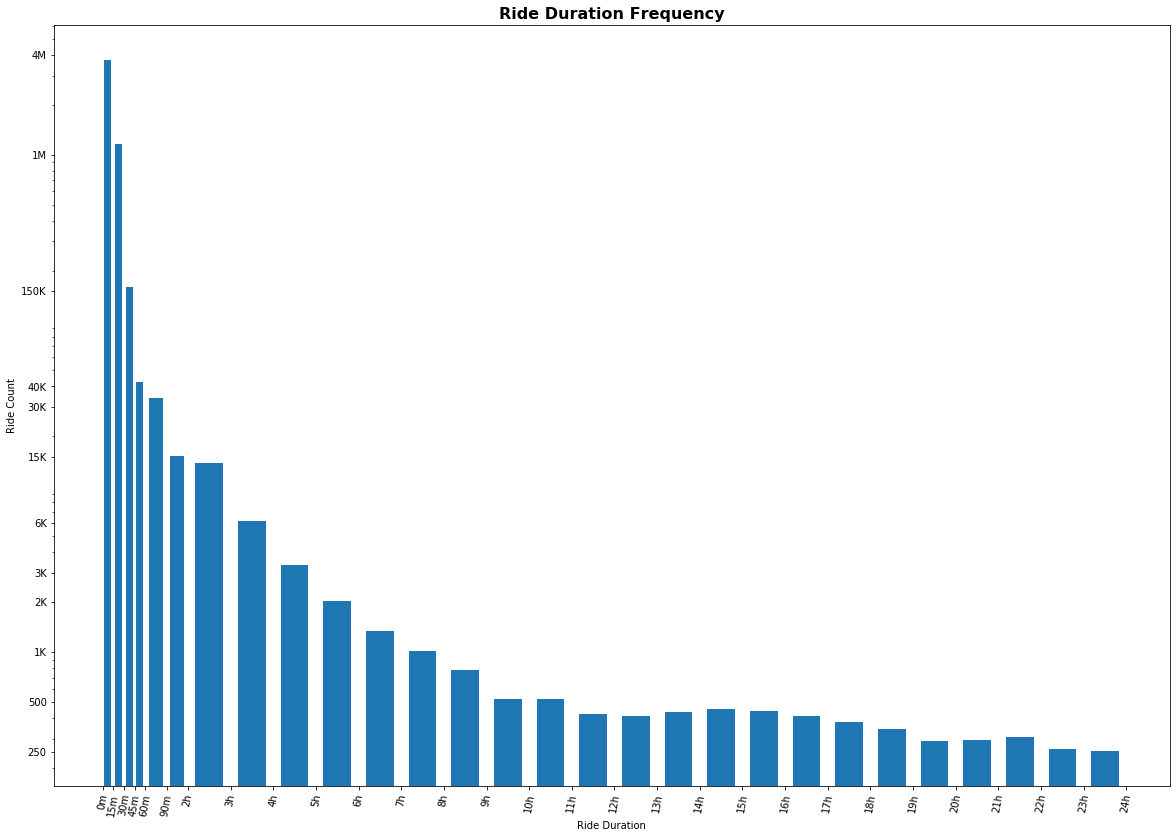

In [77]:
less_than_a_day = df.query('duration_min < 24 * 60').duration_min # There are only two rides that are greater than 24h
plt.figure(figsize=(20,14))
yticks = [ 250, 500, 1000, 2000, 3000, 6000, 15000, 30000, 40000, 150000, 1000000, 4000000]
ylabels = [ 250, 500, "1K", "2K", "3K", "6K", "15K", "30K", "40K", "150K", "1M", "4M"]

xticks = [ 0, 15, 30, 45, 60, 90 ]
xticks.extend([*range(120, 1500, 60)])

def fmtxlabel(l):
    if l <= 90:
        return "{}m".format(l)
    else:
        return "{}h".format(int(l/60))

xlabels = list(map(lambda x : fmtxlabel(x), xticks))
plt.hist(less_than_a_day, bins = xticks, rwidth = 0.65)
plt.yscale('log')
plt.yticks(yticks, labels = ylabels);
plt.xticks(xticks, labels = xlabels, rotation=80)
plt.xlabel("Ride Duration")
plt.ylabel("Ride Count")
plt.title("Ride Duration Frequency", fontsize = 16, fontweight = 'bold');

Looking at above graph, we can clearly see that ~80% of the rides are less than 15 minutes. Since the number of rides decreased exponentially as the duration increases, we had to plot the data on a logarthmic scale.
- Out of the 5M rides in the data set, nearly 4M are from rides less than 15minutes and 1M are between 15mins to 30mins duration.
- There are some considerable amount of rides that span up to 8h which makes sense because people might be using the bike for entire day (8 hours). The graph consistently steeps up to 8h mark.
- After 9h mark, the graph nearly flattens out with no significant decrease. This may be interesting and we can perhaps do some more deeper user based analysis and baywheels can use the user data from these rides for some targetted promotions.

### Year wise breakdown

**NOTE**
- Baywheels launched in 2017 June (Or atleast that is where the dataset begins)
- We have data for only one month (January) in 2020.

We can plot the number of ride count per each year keeping above in mind.

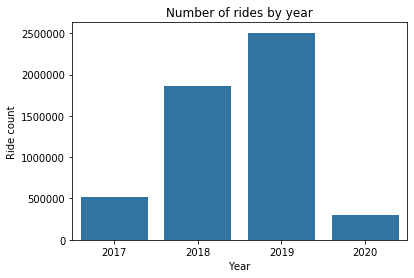

In [55]:
# Ride count per year
sb.countplot(x = 'ride_year', data = df, color = sb.color_palette()[0])
plt.xlabel("Year")
plt.ylabel("Ride count")
plt.title("Number of rides by year");

The year wise breakdown clearly shows that the baywheels is a booming business with consistent growth year after year. We can use this to predict a growth rate for 2020 which can be used to make any business expansion decisions.

### Breakdown of rides by weekday

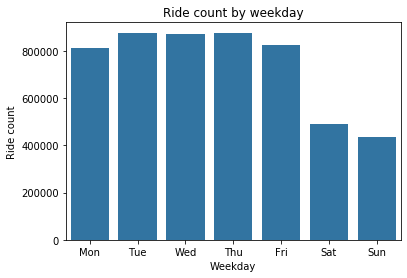

In [80]:
sb.countplot(data = df, x = 'ride_weekday', order = sorted_weekdays, color = sb.color_palette()[0])
plt.xlabel("Weekday")
plt.ylabel("Ride count")
plt.title("Ride count by weekday");

It is apparent that the usage dips during the weekends. This could be because people use the bikes in the city for commute or daily chores during weekdays and would like to getaway during the weekends. It would be interesting to explore this pattern further by categorizing the usage by user type. We can do this in bivariate analysis.

### Rental access method preference

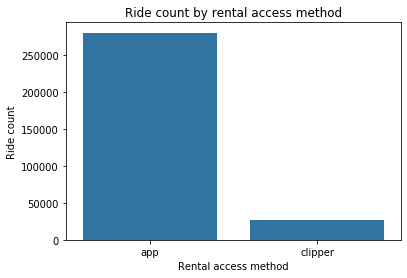

In [81]:
sb.countplot(data = df, x = 'rental_access_method', color = sb.color_palette()[0])
plt.xlabel("Rental access method")
plt.ylabel("Ride count")
plt.title("Ride count by rental access method");

The `rental_access_method` is absent prior to 2019 and it seems that many users prefer app over the clipper card.

### Bike share for all trip performance

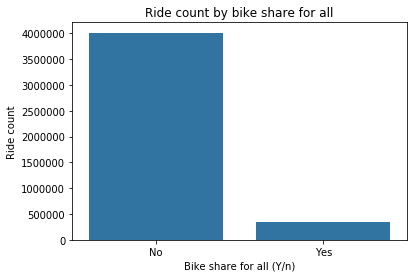

In [82]:
sb.countplot(data = df, x = 'bike_share_for_all_trip', color = sb.color_palette()[0])
plt.xlabel("Bike share for all (Y/n)")
plt.ylabel("Ride count")
plt.title("Ride count by bike share for all");

This is also a very straighforward graph with very less number of rides coming from bike share for all program. Perhaps this program was not a hit or this could be lack of awareness amongst the users about the program. 

### User type breakdown

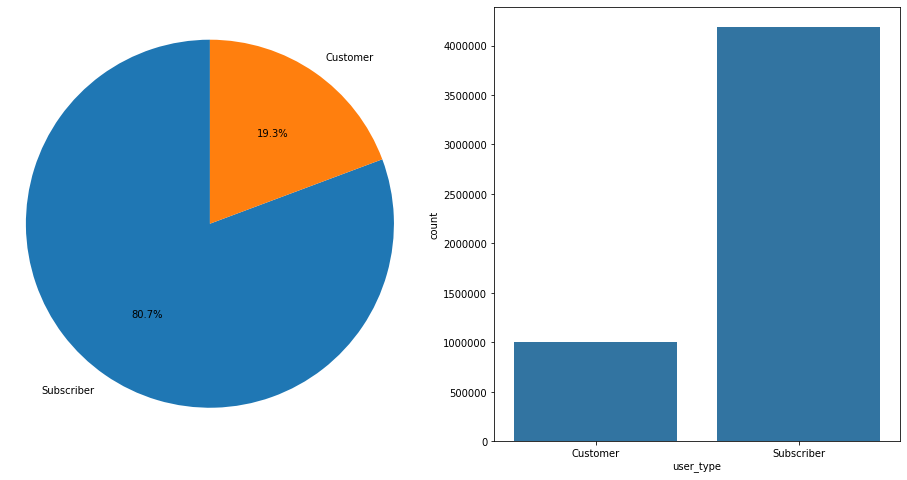

In [86]:
plt.figure(figsize=[16, 8])
plt.subplot(1, 2, 1)
u = df.user_type.value_counts() * 100 / df.user_type.value_counts().sum()
plt.pie(u.values, labels = u.index, startangle = 90, autopct='%1.1f%%')
plt.axis("equal")

plt.subplot(1, 2, 2)
sb.countplot(data = df, x = 'user_type', color = sb.color_palette()[0]);

From the above charts, we can infer that most number of rides come from the subscribers but customers form a considerable proportion of the total user group. It would be interesting to see various patterns between these two user categories.

### Ride hour (start hour of the ride) frequency

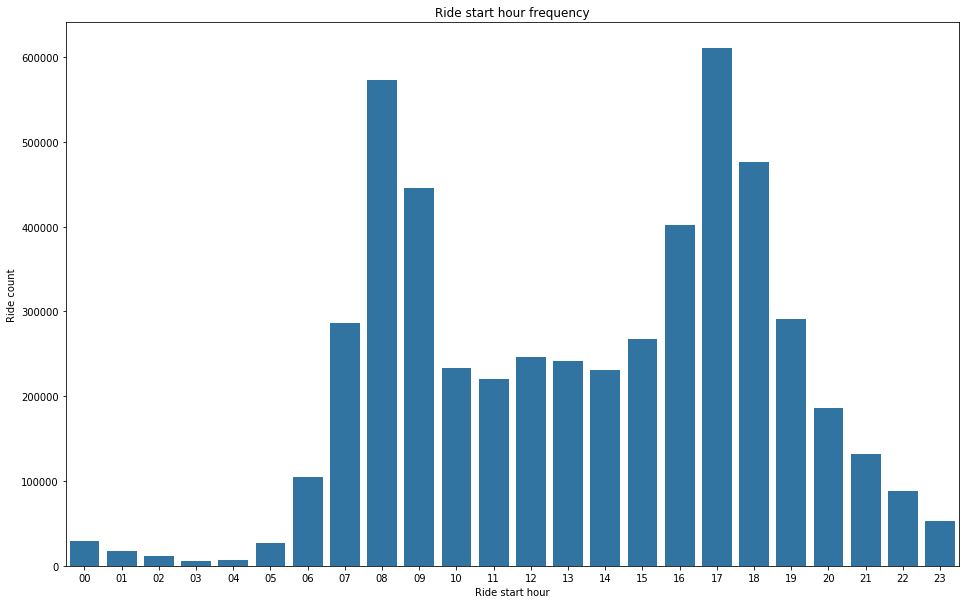

In [90]:
plt.figure(figsize=(16,10))
sb.countplot(data = df, x = 'ride_hour', color = sb.color_palette()[0])
plt.xlabel("Ride start hour")
plt.ylabel("Ride count")
plt.title("Ride start hour frequency");

Looking at above graph it is apparent that commute hours (around 8AM and then again at around 5PM) seems to be most common times of the day where baywheels sees the peak usage. This can be used to drive business decisions such as availability, promos etc..,

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

As discussed in previous sections, the ride count data when categorized by `duration_min` was a highly non linear data  with values ranging from hundreds to millions (200 to 4M to be more precise). To better understand the actual distribution and to improve the readability of the chart, using a logarthmic scale seemed to be a better approach. This ended up generating a very insightful/readable graph on how the rides are distributed over `duration_min`


### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

The data was considerably clean and there were very little to none outliers. There were some missing values but these did not affect the overall quality of the dataset (for e.g.: ride access method was relatively new and it was not present prior to 2018). These sort of missing values did not need to be cleaned.

Not exactly tidying up, but since it gets non trivial to parse year, month, day from the start time of the ride, we had to introduce new columns for these fields for making various kinds of analysis easier.

---

## Bivariate Exploration

### Customer vs Subscriber on weekdays

As discussed in previous section, we can explore the usage pattern between customers and subscribers by weekday

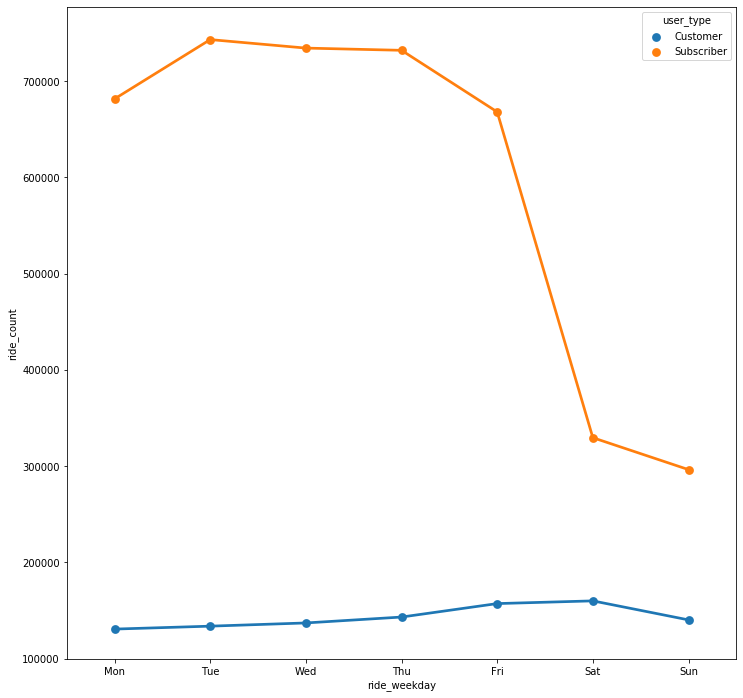

In [27]:
# Customer vs Subscriber on weekdays

user_weekday_rides = df.groupby(["ride_weekday", "user_type"]).size().reset_index()
user_weekday_rides.rename(columns = {0: 'ride_count'}, inplace=True)
plt.figure(figsize=(12,12))
sb.pointplot(x = 'ride_weekday', y = 'ride_count', hue = 'user_type', data = user_weekday_rides, order = sorted_weekdays);

The above chart reveals an interesting pattern. While the Subscibers bring the highest number of rides, their usage dips significantly during weekends. In contrast, the usage of the customers (althought low relatively speaking) peaks during the weekends. This may be because the subscribers often use the rides for commutes and daily chores while the customers often use the rides during weekends for touring the city or any fun related activities. This is a very important revelation and can be used to drive multiple business decisions.


### Duration(in mins) by user type.

After exploring the number of rides by weekday, we can further analyse the user type by comparing the duration mins.

<Figure size 864x864 with 0 Axes>

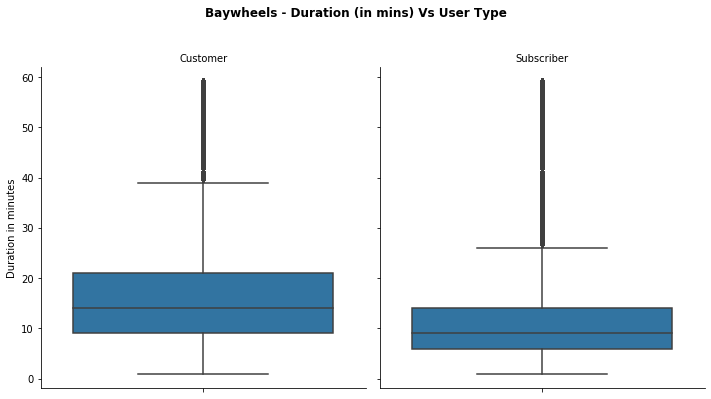

In [91]:
# 60mins is reasonable because nearly 90% of the rides are in < 30mins category.
less_than_hour = df.query('duration_min < 60')

plt.figure(figsize=(12,12));
boxplot = sb.catplot(kind = 'box', data = less_than_hour, y = 'duration_min', col = 'user_type')
boxplot.set_axis_labels("", "Duration in minutes")
boxplot.fig.suptitle("Baywheels - Duration (in mins) Vs User Type", y = 1.1, fontweight = 'bold')
boxplot.set_titles(col_template = '{col_name}');

Looking at the above box plot, it is clear that customers usually keep the bike for longer durations compared to the subscribers. Also, this speaks in relation to our earlier graph on high weekend usage for customers compared to subscribers. This can be used to target marketing based on ride duration differently betweent subscribers and customers.

### Rental Access (Clipper vs App) 

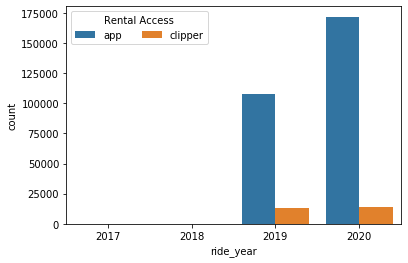

In [92]:
# bike_share_for_all_trip
g = sb.countplot(data = df, x = 'ride_year', hue = 'rental_access_method')
g.legend(loc = 'upper left', ncol = 2, title = 'Rental Access');

Looking at above chart, although rental access data is included 2019 and above, many users prefer to use app over the clipper card (which is a local transit card). This can be used to drive business decisions such as providing transit discount like many local transists that provide discounted fare if using clipper card.


### Bike share for all (Yes/No)

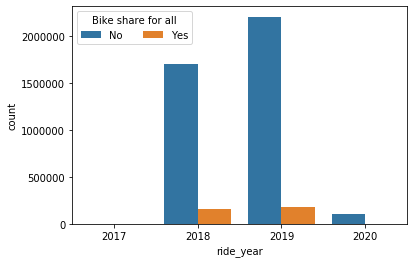

In [93]:
# bike_share_for_all_trip
b = sb.countplot(data = df, x = 'ride_year', hue = 'bike_share_for_all_trip')
b.legend(loc = 'upper left', ncol = 2, title = 'Bike share for all');

From above char, we can infer that since the inception of the program, although we see a slight growth rate in `Yes` value from 2018 to 2019, many rides are still not from the bike share for all program.

### Month wise breakdown for each year

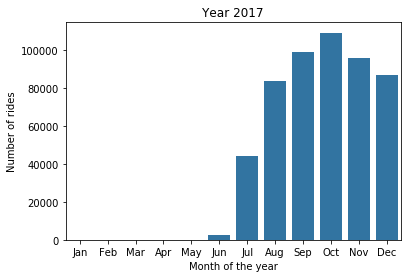

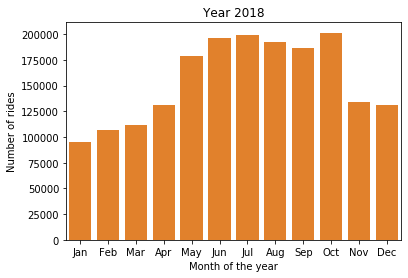

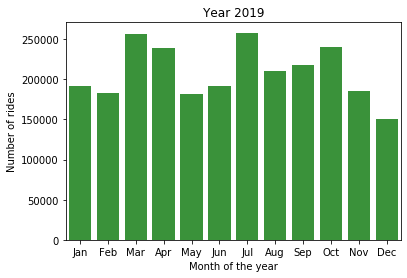

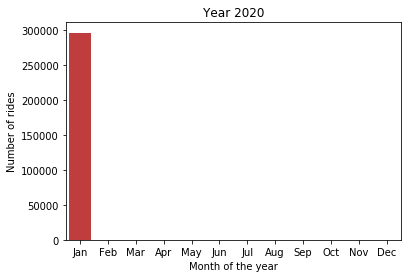

In [79]:
for year in range (2017, 2021):
    color = sb.color_palette()[year % 2017]
    year_data = df.query("ride_year == '{}'".format(year))
    sb.countplot(data = year_data, x = 'ride_month', order=sorted_months, color = color)
    plt.title("Year {}".format(year))
    plt.ylabel("Number of rides")
    plt.xlabel("Month of the year")
    plt.show()

* Month wise breakdown for each year clearly shows that 'October' seems to be a good month for bike rides across all years. This could be explained owing to the fact that october has fairly good weather in San francisco. 
* If we do an year by year breakdown its clear that in 2018 July and October seems to have peaked in bike rides owing to the good climate in summer and early autumn. 
* '2019' seems to follow the same trends with reagrds to july and october and also interestingly March and April months seems to have good numbers compared to 2018. As march and april marks the end of winters this could be the reason for these peaks. This could be analysed along with weather patterns and any other events happening in those months for further analysis
* It is noteworthy to see that 2020 January has highest bike rides in comparision with bike rides in any given months in past years. We could deduce the incresing popularity of GoBike sharing app.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

Finding the behaviorial differences between Customer and Subcribers seemed to be the most challenging aspect. Customers and Subscribers behaved differently when it came to ride duration (in mins) and the day of week.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

Rental Access method and Bike share for all were explored as well and it seems that these programs are still upcoming and many riders are still not using clipper card and not opting for bike share for all. This could be because of lack of awareness or could be simply because of inelgibility (in case of bike share for all program). 

---

## Multivariate Exploration


### Heatmap for Customer & Subscriber weekday rides by hour of the day.

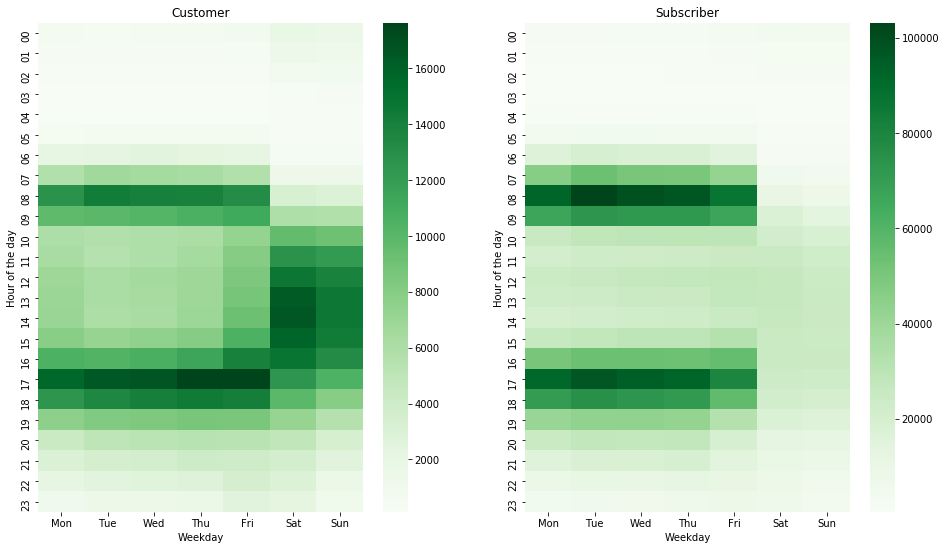

In [94]:
# heatmap for weekeday vs hour of day for customers and subscribers.
plt.figure(figsize=(16, 9))
graphs = [(1, 'Customer'), (2, 'Subscriber')]
for g in graphs:
    plt.subplot(1, 2, g[0])
    custs = df[df.user_type == g[1]].groupby(["ride_hour", "ride_weekday"]).size().reset_index()
    custs.rename(columns = {0: 'count'}, inplace=True)
    custs = custs.pivot(index = 'ride_hour', columns = 'ride_weekday', values = 'count')
    sb.heatmap(custs, cmap='Greens')
    plt.title(g[1])
    plt.xlabel("Weekday")
    plt.ylabel("Hour of the day")

The above chart reveals following interesting statistics:

- Customers and Subscribers peak during the commute hours on weekdays
- Customer rides increase during weekends and Subscriber rides decrease during weekends
- On the weekends, Customer rides spike during noon and the heatmap is generally denser throughout the day.
- Irrespective of user type, there are very less rides during off hours (11 PM to 5 AM) generally.

### Clustered bar graph for Customer & Subscribers by ride month across years.

<Figure size 1440x1440 with 0 Axes>

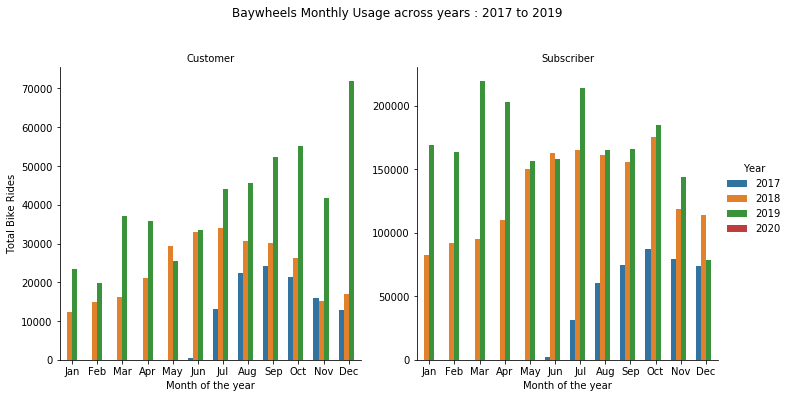

In [95]:
df_non_2020 = df.query('ride_year != "2020"')
plt.figure(figsize=(20, 20))
g = sb.catplot(data = df_non_2020, x = 'ride_month', col = 'user_type', hue = 'ride_year', sharey = False, kind = 'count')
g.set_axis_labels("Month of the year", "Total Bike Rides")
g.set_titles("{col_name}")
g._legend.set_title("Year")
plt.suptitle("Baywheels Monthly Usage across years : 2017 to 2019", y = 1.1);

We can make following deduction from the above graphs:

- In year 2019, we saw a huge spike in rides from subscribers during early months (Jan - Apr) season.
- In year 2018, there is a similar shape for the highs and lows irrespective of user type. This was not the case for the 2019 however.
- In year 2017, we had a good launch as the number of rides by subscribers consistently increased since inception until the end of the year and onward to 2018.
- Decemeber of 2019 seems to be very unique it terms it saw very less number of rides from subscribers (even less than Dec 2018) while it also saw most number of rides from customer ever in a single month. Although this is a single occurence, we can do further analysis with this statistic as to what went wrong (or good).
- Irrespetive of the user type and year, we always have consistent growth in each month.



### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

Looking at the heatmaps for customer and subscriber usage, it further strengthened our observations in univariate and bivariate analysis on ride hour and ride weekday. Each feature played very well with other features in these multivariate analysis.


### Were there any interesting or surprising interactions between features?

Looking at the clustered graph for monthly analysis across years yielding some surprising results about the month of December 2019 for Subscriber vs Customer.

## References

[1] https://en.wikipedia.org/wiki/Bay_Wheels